This notebook functionizes the 'Array to ASPA'. Goal is to convert any input dictionary to a usable ASPA for analysis.

IMPORTANT:
During the visualisation of the images. Each cmap per individual image is scaled depending on the contents. Therefor the images array has to be saved and used... Saving the PNG's will give faulty results. 

TODO:
Split up all features into e.g. 4 scales so they can be scaled and distuingished better?
But also reserve space for 'cloud' models. 

# Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from keijzer_exogan import *


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

# Load chunk

In [2]:
dir_ = '/datb/16011015/ExoGAN_data//'

X = load_all_to_array(dir_, 'chunck_0.pkgz')

np.random.seed(23) # Set seed for the np.random functions

# Shuffle X along the first axis to make the order of simulations random
np.random.shuffle(X) # note that X = np.rand.... isn't required

100%|██████████| 1/1 [00:12<00:00, 12.51s/it]


In [3]:
X

array([{'data': {'spectrum': array([0.02327297, 0.02323489, 0.02324177, 0.02325603, 0.02323125,
       0.02325396, 0.02324845, 0.02324477, 0.02324291, 0.02324494,
       0.02324165, 0.02325761, 0.02324385, 0.02325337, 0.02324956,
       0.02325874, 0.02324763, 0.02325021, 0.0232516 , 0.0232431 ,
       0.02325732, 0.02326607, 0.02326398, 0.02325707, 0.02325778,
       0.02326503, 0.02325858, 0.02325407, 0.02325698, 0.02326019,
       0.02325904, 0.02325762, 0.02325426, 0.02326424, 0.02326414,
       0.02325978, 0.02326646, 0.0232533 , 0.02325451, 0.02324916,
       0.02325717, 0.02325545, 0.02327855, 0.02325475, 0.02324673,
       0.02325301, 0.02325131, 0.02323979, 0.02326333, 0.02324801,
       0.02325405, 0.02325168, 0.02324744, 0.02325451, 0.02323959,
       0.02325187, 0.02324391, 0.02326678, 0.02325596, 0.0232472 ,
       0.02324517, 0.02325248, 0.02324964, 0.0232629 , 0.02325585,
       0.02326244, 0.02326578, 0.02325879, 0.02327595, 0.02327258,
       0.02327597, 0.02327367, 0.

In [13]:
# scale the data
def scale_param(X, X_min, X_max):
    """
    Formule source: 
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    In this case 1 is max, 0 is min
    """
    std = (X-X_min)/ (X_max - X_min)
    return std*(1 - 0)+0

In [14]:
cmap = 'gray'

    """
    Transforms the input dictionary (in the format of ExoGAN), to the ASPA format.
    TODO:
    
    - devide each parameter in bins and scale the data per bin (to hopefully increase the contrast in the data)
    - make sure to leave space for cloud model information (max2, min2 is currently double info from max1, min1)
    """
    
    spectrum = x['data']['spectrum']

    if len(spectrum) != 515:
        print('Spectrum length != 515. breaking script')
        #break

    """
    Scale the spectrum
    """
    spectrum = spectrum.reshape(-1, 1) # convert 1D array to 2D cause standardscaler requires it

    scaler = MinMaxScaler(feature_range=(0,1)).fit(spectrum)
    std = np.std(spectrum)
    min_ = spectrum.min()
    max_ = spectrum.max()

    spectrum = scaler.transform(spectrum)

    # fill spectrum to have a size of 529, to then reshape to 23x23
    spectrum = np.append(spectrum, [0 for _ in range(14)]) # fill array to size 529 with zeroes
    spectrum = spectrum.reshape(23, 23) # building block one
    
    # Also scale min_ max_ from the spectrum
    min_ = scale_param(min_, 6.5e-3, 2.6e-2)
    max_ = scale_param(max_, 6.5e-3, 2.6e-2)

    """
    Add the different building blocks to each other
    """

    max1 = np.full((12,6), max_) # create array of shape 12,6 (height, width) with the max_ value
    min1 = np.full((11,6), min_)
    max1min1 = np.concatenate((max1, min1), axis=0) # Add min1 below max1 (axis=0) 

    image = np.concatenate((spectrum, max1min1), axis=1) # Add max1min1 to the right of spectrum (axis=1)

    """
    Get all parameters and scale them
    """
    # Get the param values
    ch4 = x['param']['ch4_mixratio']
    co2 = x['param']['co2_mixratio']
    co = x['param']['co_mixratio']
    h2o = x['param']['h2o_mixratio']
    mass = x['param']['planet_mass']
    radius = x['param']['planet_radius']
    temp = x['param']['temperature_profile']

    # Scale params (parm, min_value, max_value) where min/max should be the 
    ch4 = scale_param(ch4, 1e-8, 1e-1)
    co2 = scale_param(co2, 1e-8, 1e-1)
    co = scale_param(co, 1e-8, 1e-1)
    h2o = scale_param(h2o, 1e-8, 1e-1)
    mass = scale_param(mass, 1.5e27, 3.8e27)
    radius = scale_param(radius, 5.6e7, 1.0e8)
    temp = scale_param(temp, 1e3, 2e3)

    # Create the building blocks
    co2 = np.full((23,1), co2)
    co = np.full((23,1), co)
    ch4 = np.full((23,1), ch4)


    mass = np.full((1,23), mass)
    radius = np.full((1,23), radius)
    temp = np.full((1,23), temp)

    h2o = np.full((9,9), h2o)

    max2 = np.full((6,12), max_) # create array of shape 12,7 (height, width) with the max_ value
    min2 = np.full((6,11), min_)

    """
    Put building blocks together
    """
    image = np.concatenate((image, co2), axis=1)
    image = np.concatenate((image, co), axis=1)
    image = np.concatenate((image, ch4), axis=1)

    sub_image = np.concatenate((max2, min2), axis=1)
    sub_image = np.concatenate((sub_image, mass), axis=0)
    sub_image = np.concatenate((sub_image, radius), axis=0)
    sub_image = np.concatenate((sub_image, temp), axis=0)
    sub_image = np.concatenate((sub_image, h2o), axis=1)

    image = np.concatenate((image, sub_image), axis=0)

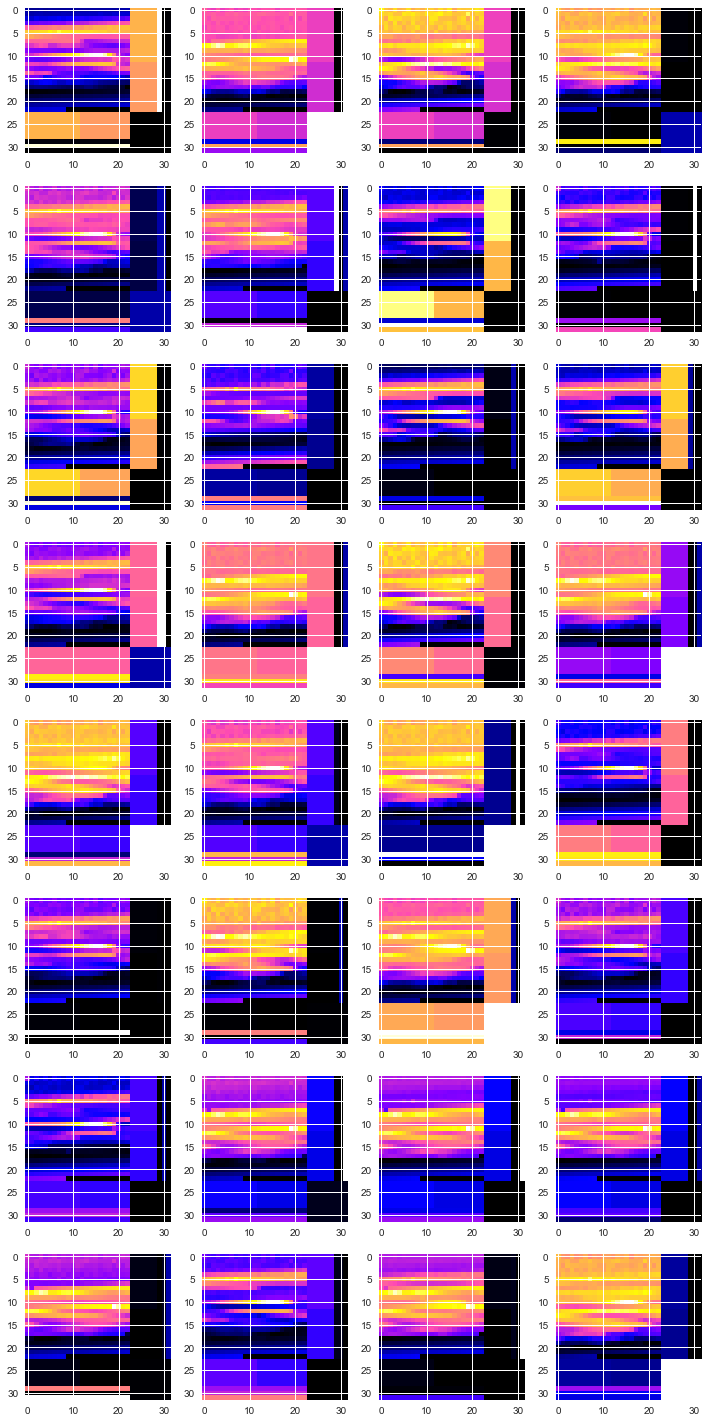

In [15]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    image = dict_to_ASPA(X[i])
    

    plt.subplot(8, 4, i+1)
    plt.imshow(image, cmap='gnuplot2')
    plt.tight_layout()

# Creating images from all simulations in the chunk

In [16]:
images = []
for i in tqdm(range(len(X))):
    image = dict_to_ASPA(X[i])
    image = image.reshape(1, 32, 32) # [images, channel, width, height]
    images.append(image)
    
images = np.array(images)
images.shape

  2%|█▍                                                                      | 23794/1200000 [00:09<08:12, 2386.26it/s]c:\program files\python36\lib\site-packages\tqdm\_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████████████████████████████████████████████████████████████████| 1200000/1200000 [11:41<00:00, 1711.68it/s]


(1200000, 1, 32, 32)

# Saving this array to disk

In [ ]:
np.save(dir+'chunk_rnd_images.npy', images)

# Test loading and visualization

In [6]:
images = np.load('/datb/16011015/ExoGAN_data/selection/first_chunks_25_percent_images.npy')

In [51]:
images.shape

(500000, 1, 32, 32)

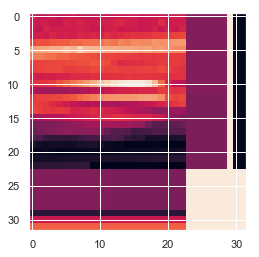

In [52]:
plt.imshow(images[0,0,:,:])

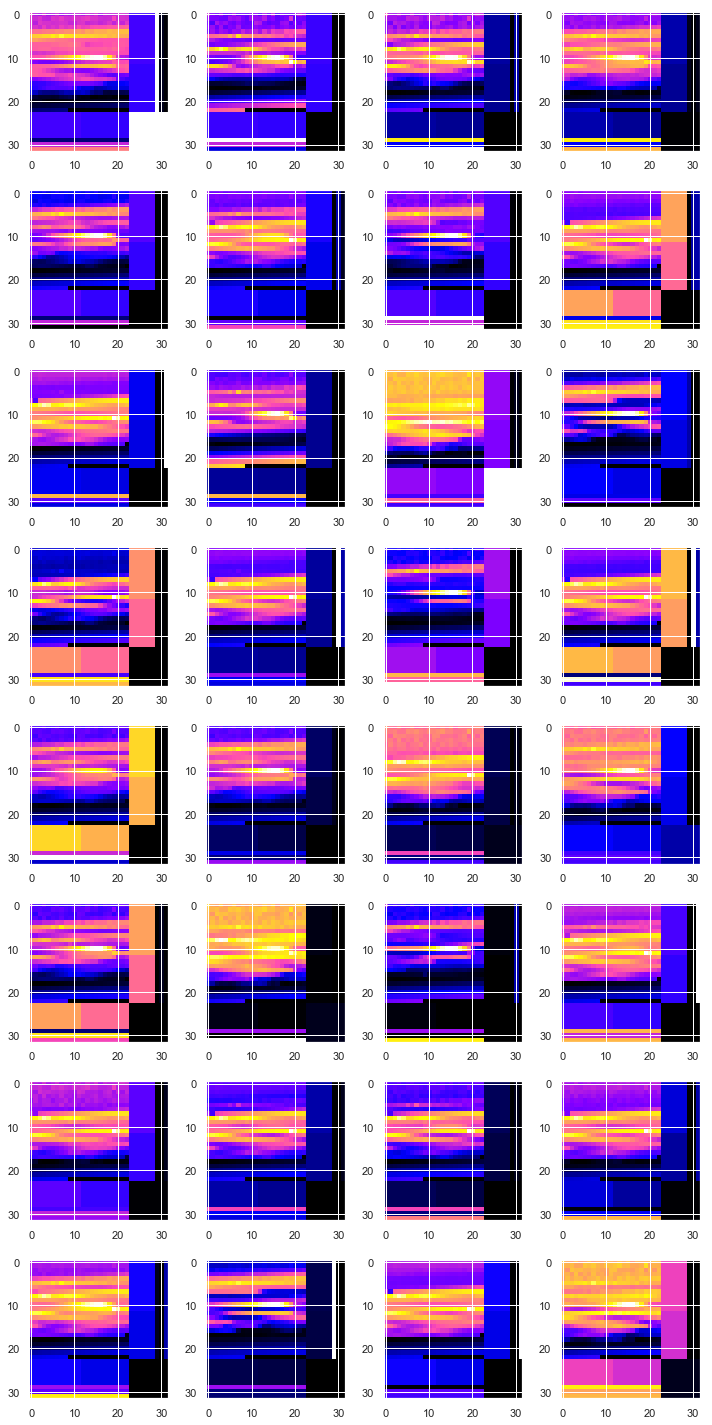

In [9]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i,0,:,:], cmap='gnuplot2')
    plt.tight_layout()

# Randomly mask pixels from the encoded spectrum

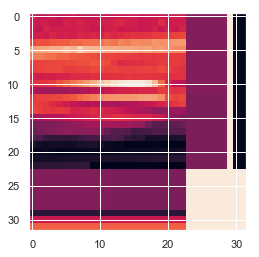

In [57]:
image = images[0, 0, :, :]
plt.imshow(image)

(32, 32)


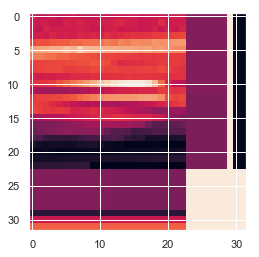

In [119]:
# image[:23, :23] is the encoded spectrum.
t = image.copy()
print(t.shape)
#t[:23, :23] = 0
plt.imshow(t)

# Random uniform dropout

In [120]:
t = image.copy()
dropout = 0.9

for i in range(24): # loop over rows
    for j in range(24): # loop over cols
        a = np.random.random() # random uniform dist 0 - 1
        if a < dropout:
            t[i-1:i, j-1:j] = 0
        else:
            pass

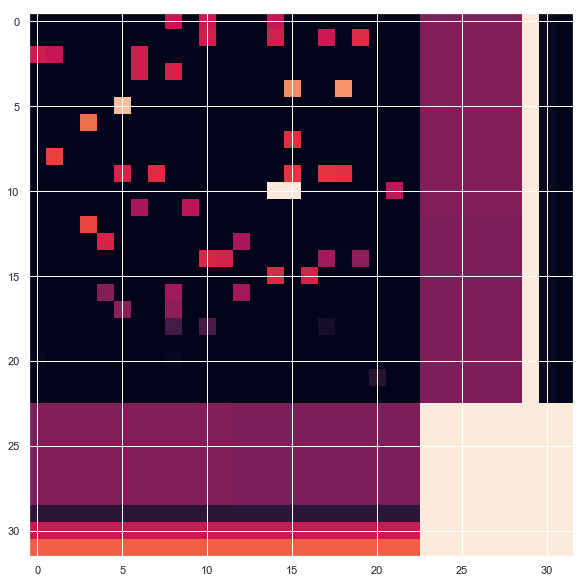

In [121]:
plt.figure(figsize=(10,10))
plt.imshow(t)

(32, 32)

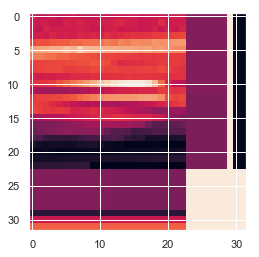

In [19]:
# image[:23, :23] is the encoded spectrum.
t = image.copy()

#t[:23, :23] = 0
plt.imshow(t)
t.shape

# Range dropout

In [ ]:
# TODO: Mask everything but the visible spectrum

def mask_image(image, visible_length, random_visible_spectrum=True):
    """
    Masks everything in an input image, apart from the start to visible_length. 
    
    start = start wavelength/index value of the visible (non masked) spectrum
    visible_length = length of the visible spectrum (in pixels)
    output: masked_image
    """

    image_masked = image.copy()
    
    spectrum_length = 23*23 # length of spectrum in ASPA
    start_max = spectrum_length - visible_length # maximum value start can have to still be able to show spectrum of length visible_length
    start = np.random.randint(0, start_max)

    # start stop index to mask before the visible (not masked) spectrum / sequence

    stop = start + visible_length # stop index of unmasked sequence

    spectrum = image_masked[:23, :23].flatten() # flatten the spectrum
    spectrum[:start] = 0
    spectrum[stop:] = 0
    spectrum = spectrum.reshape(23, 23)

    #t[:, :] = 0

    image_masked[:23, :23] = spectrum

    image_masked[:, 29:] = 0 # right side params
    image_masked[29:, :] = 0 # bottom params
    image_masked[23:, 23:] = 0 # h2o

    image_masked = image_masked.reshape(1, 32, 32) # add the channel dimension back 
    
    return image_masked


image = images[0, 0, :, :].copy()
visible_length = 46 # length of the visible (not to mask) spectrum

image_masked = mask_image(image, visible_length)
plt.imshow(image_masked[0, :, :])

## Also mask params and h2o
Leaving min max values for now (they will get updated anyway)

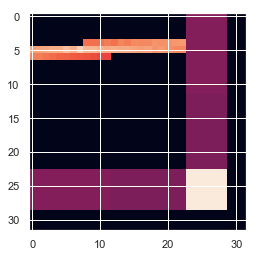